In [4]:
##import modules
import os
import pickle
import numpy 
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [5]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [6]:
##load vgg16 model
model = VGG16()
##restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

I0000 00:00:1771660586.577117  713727 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771660586.582324  713727 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
import os
print(os.listdir('/kaggle/input'))

['datasets']


In [8]:
import os
print(os.listdir('/kaggle/input/datasets'))


['adityajn105']


In [9]:
import os
print(os.listdir('/kaggle/input/datasets/adityajn105'))


['flickr8k']


In [10]:
import os
print(os.listdir('/kaggle/input/datasets/adityajn105/flickr8k'))


['captions.txt', 'Images']


In [11]:
# Step 1: Pehle features variable clear karo


# Step 2: Extraction loop dobara chalao
features = {}
directory = '/kaggle/input/datasets/adityajn105/flickr8k/Images'

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature  # 'features' mein store ho raha hai, 'feature' mein nahi

# Step 3: Verify
print(type(features))  # dict hona chahiye
print(len(features))   # 8091 hona chahiye

# Step 4: Save
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1771660591.362221  713790 service.cc:152] XLA service 0x7c44bc003900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771660591.362251  713790 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771660591.362255  713790 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771660591.550511  713790 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1771660594.246267  713790 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<class 'dict'>
8091


In [12]:
print(type(features))
print(len(features))

<class 'dict'>
8091


In [13]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'),'wb'))


In [14]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

print(type(features))   # <class 'dict'> aana chahiye
print(len(features))    # 8091 aana chahiye

<class 'dict'>
8091


In [15]:
BASE_DIR = '/kaggle/input/datasets/adityajn105/flickr8k'

with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

print(captions_doc[:500])  


1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A bl


In [16]:
mapping ={}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line)<2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = "".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)    

  0%|          | 0/40456 [00:00<?, ?it/s]

In [17]:
len(mapping)

8091

In [18]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption
        

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_713727/3389653323.py:7: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [19]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [20]:
clean(mapping)

In [21]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [22]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [23]:
len(all_captions)

40455

In [24]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [26]:
vocab_size

8485

In [27]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [28]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [29]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    
    while True:
        for key in data_keys:
            captions = mapping[key]
            
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    feature = features[key]
                    if feature.ndim == 2:
                        feature = feature[0]
                    
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
            n += 1
            
            if n == batch_size:
                yield (np.array(X1), np.array(X2)), np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0


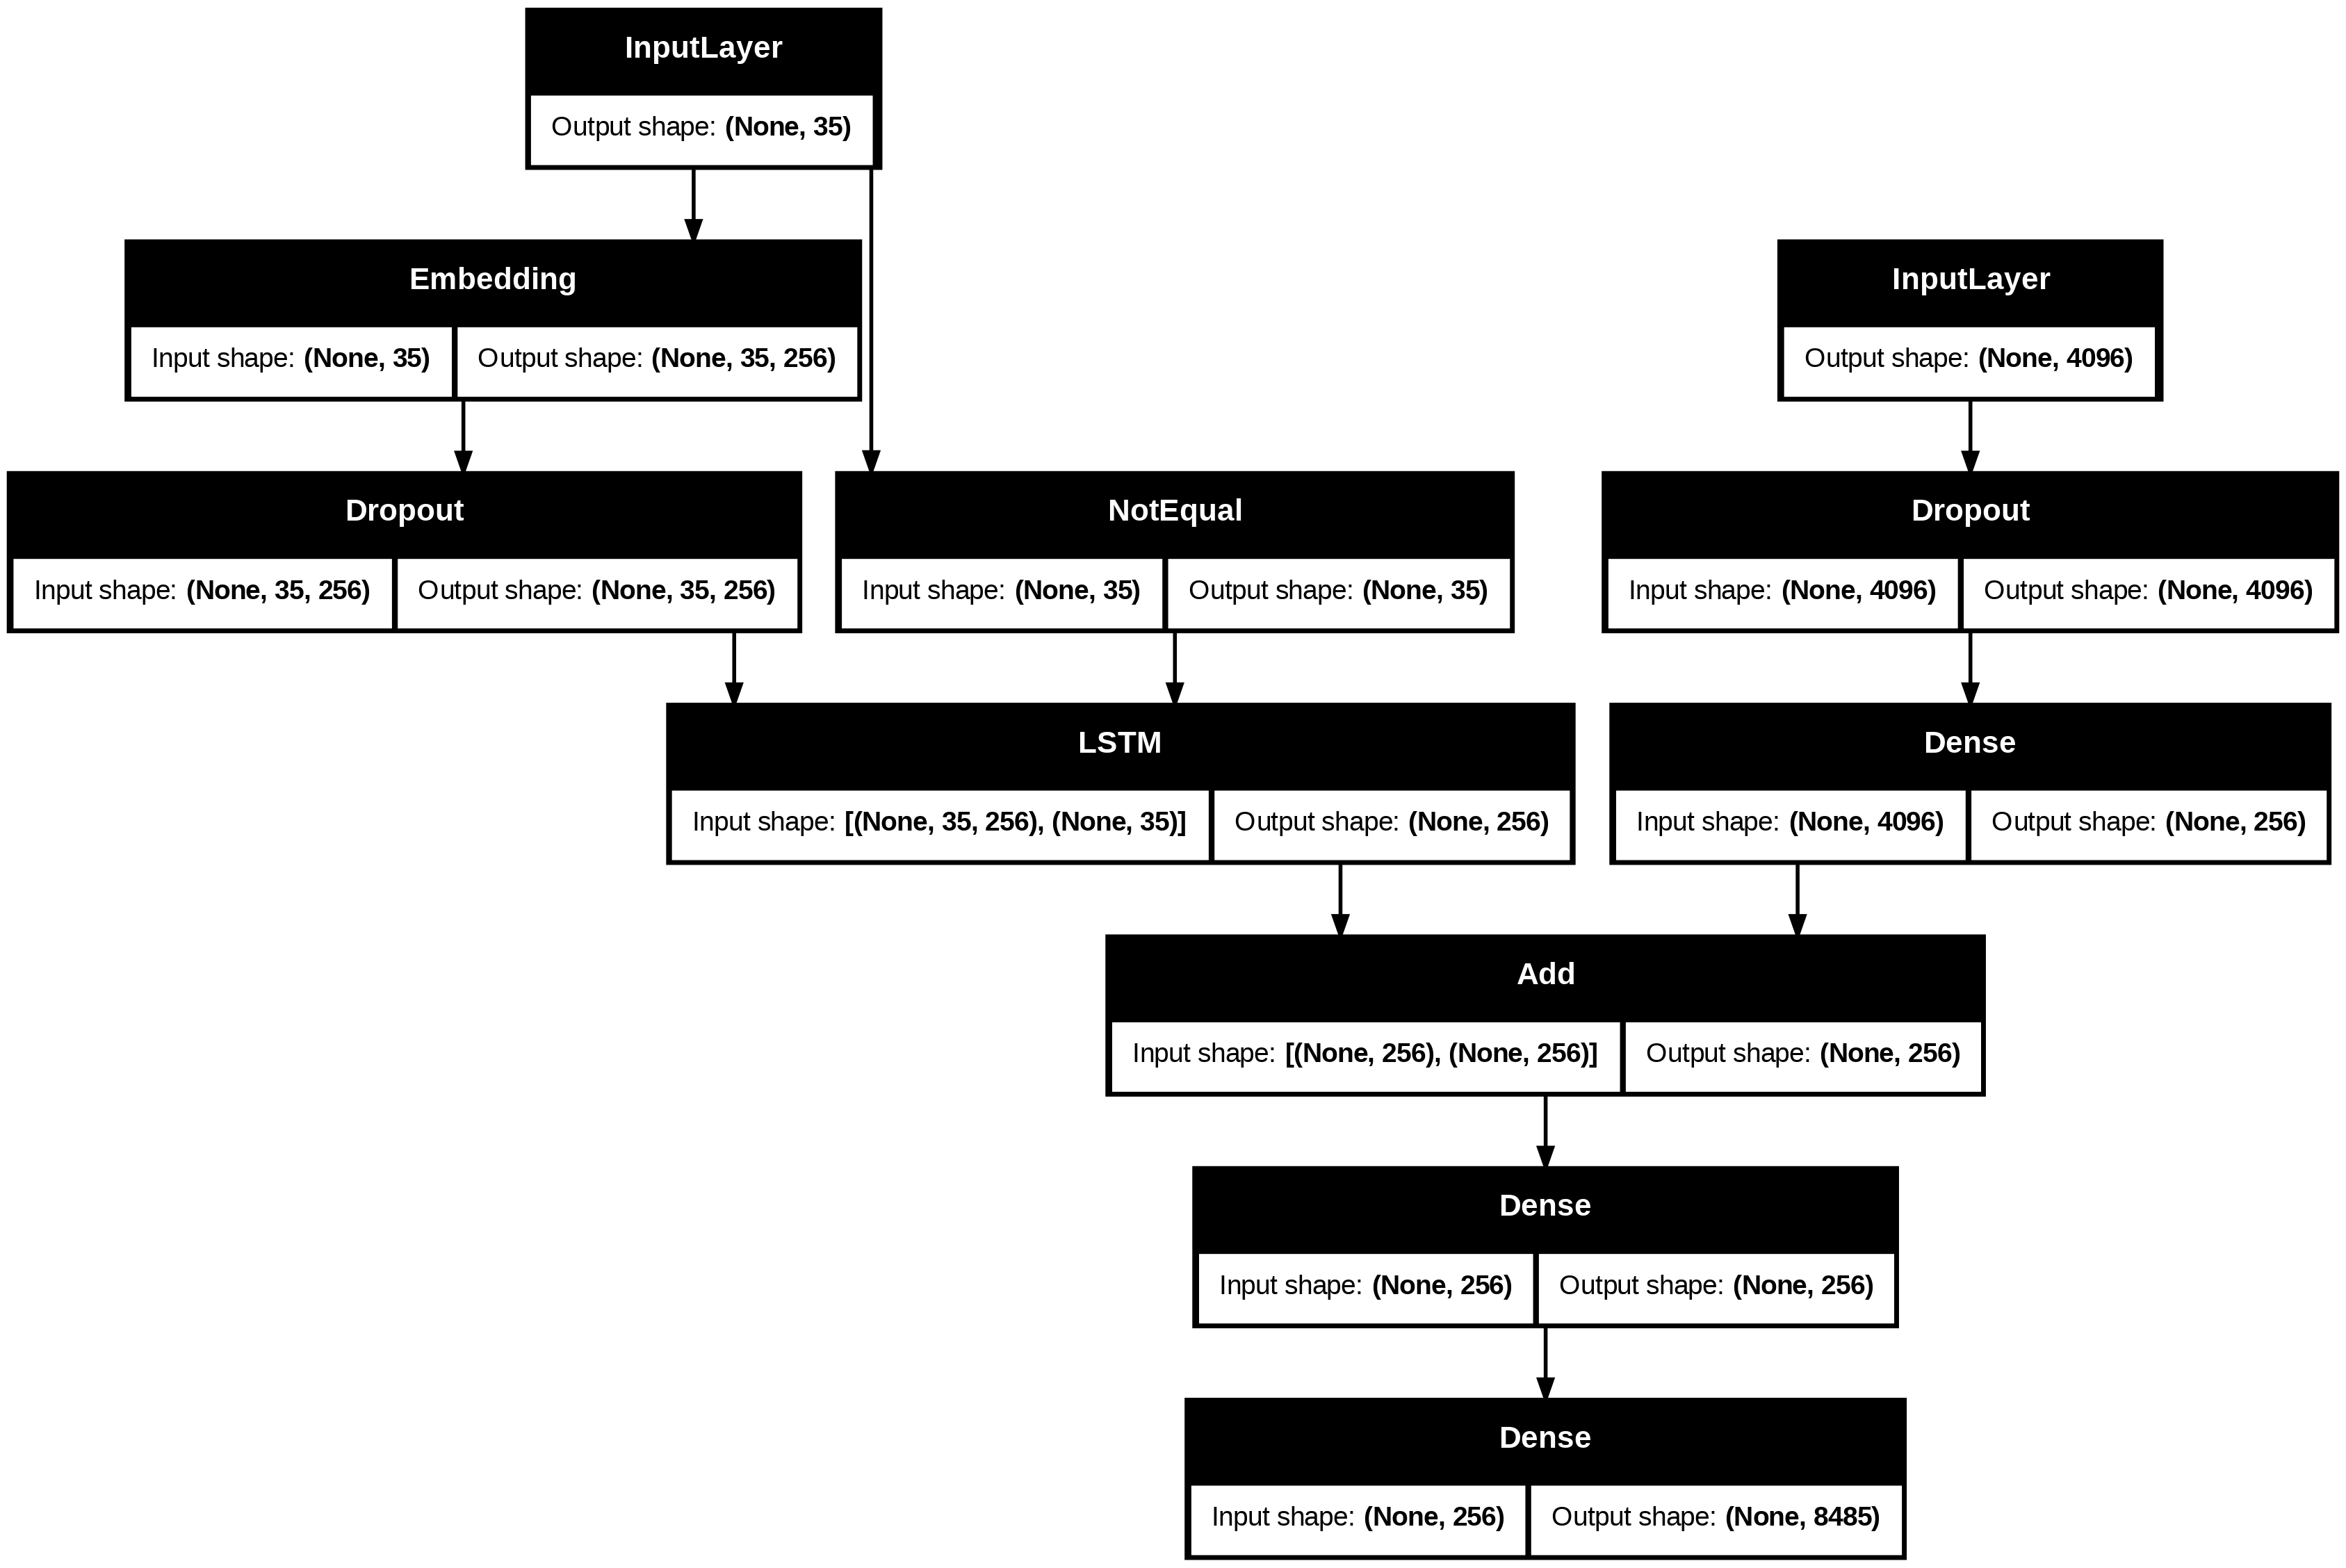

In [30]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero= True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
plot_model(model,show_shapes=True)

In [31]:
# create mapping from image_id to index
image_ids = list(mapping.keys())
feature_index = {image_ids[i]: i for i in range(len(image_ids))}


In [32]:
print(len(features))   # 8091 aayega
print(len(train))      # 7281 aayega

8091
7281


In [33]:
pickle.dump(features, open('/kaggle/working/features.pkl', 'wb'))

In [34]:
features = pickle.load(open('/kaggle/working/features.pkl','rb'))
print(type(features))
print(len(features))


<class 'dict'>
8091


In [35]:
import os
print(os.listdir('/kaggle/working'))


['.virtual_documents', 'best_model.h5', 'model.png', 'features.pkl']


In [36]:
import os
os.remove('/kaggle/working/features.pkl')


In [37]:
print(type(features))
print(len(features))


<class 'dict'>
8091


In [38]:
import pickle
pickle.dump(features, open('/kaggle/working/features.pkl', 'wb'))


In [39]:
features_loaded = pickle.load(open('/kaggle/working/features.pkl', 'rb'))

print(type(features_loaded))
print(len(features_loaded))


<class 'dict'>
8091


In [40]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

In [41]:
epochs = 30
batch_size = 32
steps = len(train) // batch_size 
for i in range(epochs):
    generator = data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    model.fit(generator,epochs = 1, steps_per_epoch = steps,verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - loss: 5.7939
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - loss: 4.0848
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 3.6026
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 202ms/step - loss: 3.3136
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 3.1120
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - loss: 2.9572
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 2.8377
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 200ms/step - loss: 2.7437
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 2.6625
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 2.5922
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - loss: 2.5321
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - loss: 2.4736
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - loss: 2.4245
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - loss: 2.3784
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - loss: 2.3346
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - loss: 2.2955
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - loss: 2.2612

In [42]:
model.save(WORKING_DIR+'/best_model.h5')

In [43]:
def idx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None        

In [44]:
def predict_caption(model,image,tokenizer,max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],max_length)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat,tokenizer)
        if word is None:
            break
        in_text += " "+word
        if word == 'endseq':
            break
    return in_text    
        

In [45]:
from nltk.translate.bleu_score import corpus_bleu
actual,predicted = list(),list()
for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.531677
BLEU-2: 0.306341


In [46]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    #image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR,"Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('-----------Actual-----------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('-----------Predicted-----------')
    print(y_pred)
    plt.imshow(image)


-----------Actual-----------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
-----------Predicted-----------
startseq two dogs are playing with toy on the street endseq


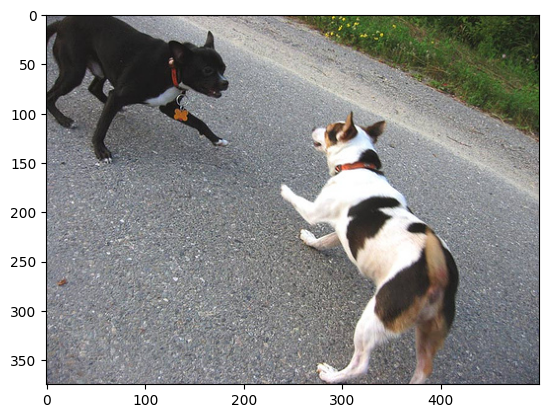

In [47]:
generate_caption("1001773457_577c3a7d70.jpg")

-----------Actual-----------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
-----------Predicted-----------
startseq girl in colorful dress sits on colorful field with world painted shoulders endseq


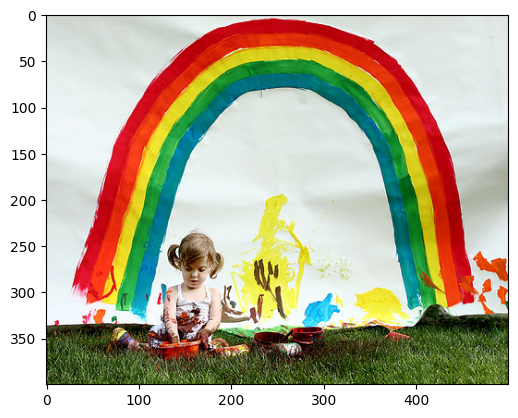

In [48]:
generate_caption("1002674143_1b742ab4b8.jpg")

-----------Actual-----------
startseq "a dog shakes its head near the shore red ball next to it ." endseq
startseq white dog shakes on the edge of beach with an orange ball endseq
startseq "dog with orange ball at feet stands on shore shaking off water" endseq
startseq white dog playing with red ball on the shore near the water endseq
startseq white dog with brown ears standing near water with head turned to one side endseq
-----------Predicted-----------
startseq dog with red collar runs along the beach endseq


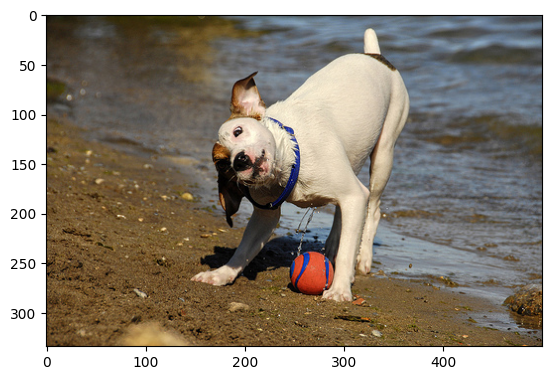

In [49]:
generate_caption("1012212859_01547e3f17.jpg")

-----------Actual-----------
startseq tent is being set up on the ice endseq
startseq two men are about to enter an ice fishing tent on snow covered lake endseq
startseq two men setting up blue ice fishing hut on an iced over lake endseq
startseq "two men standing on an ice looking into something covered with blue tarp ." endseq
startseq two people standing outside blue tent structure on snowy surface endseq
-----------Predicted-----------
startseq man in red jacket is dragging snowboard in the snow endseq


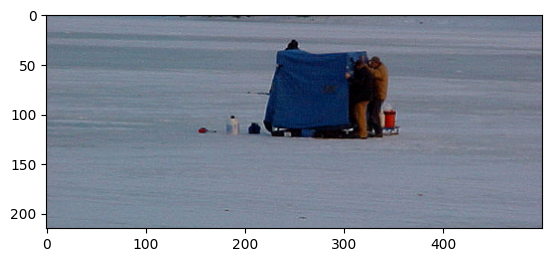

In [50]:
generate_caption("103205630_682ca7285b.jpg")